# Fruit and Vegetable Classification

About the Dataset:
- Context

    This dataset encompasses images of various fruits and vegetables, providing a diverse collection for image recognition tasks. The included food items are:
  - Fruits: Banana, Apple, Pear, Grapes, Orange, Kiwi, Watermelon, Pomegranate, Pineapple, Mango <br>

  - Vegetables: Cucumber, Carrot, Capsicum, Onion, Potato, Lemon, Tomato, Radish, Beetroot, Cabbage, Lettuce, Spinach, Soybean, Cauliflower, Bell  Pepper, Chilli Pepper, Turnip, Corn, Sweetcorn, Sweet Potato, Paprika, Jalapeño, Ginger, Garlic, Peas, Eggplant

- Content

    The dataset is organized into three main folders:

    Train: Contains 100 images per category.
    Test: Contains 10 images per category.
    Validation: Contains 10 images per category.

    Each of these folders is subdivided into specific folders for each type of fruit and vegetable, containing respective images.
- Data Collection

    The images in this dataset were sourced using Bing Image Search for a personal project focused on image recognition of food items. The creator does not hold the rights to any of the images included in this dataset. If you are the owner of any image and have concerns regarding its use, please contact the creator to request its removal. The creator will promptly comply with any such requests to ensure all legal obligations are met.

# Define infrastructure

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

from tqdm import tqdm
from PIL import Image

sns.set_style("whitegrid")

In [2]:
print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())
print("cuda version: ", torch.version.cuda if torch.cuda.is_available() else "none")

pytorch version:  2.5.1+cu118
cuda available:  True
cuda version:  11.8


In [3]:
def get_device():
  # get type of device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"device: {device}")

  # count the number of available GPU
  num_gpus = torch.cuda.device_count()

  if num_gpus:
      print("num gpus: ", num_gpus)

      for i in range(num_gpus):
          gpu_name = torch.cuda.get_device_name(i)
          print(f"GPU {i}: {gpu_name}")
  else:
      print("no GPUs are founded")

  return device

In [4]:
device = get_device()

device: cuda
num gpus:  1
GPU 0: NVIDIA GeForce RTX 2070 SUPER


# Load dataset

In [5]:
root_path = "data/36_classes"

In [6]:
import os
print(os.listdir(root_path))

['test', 'train', 'validation']



Exploring Dataset Structure:
--------------------------------------------------

Train Set:
Number of classes: 36
Total images: 3115
Example classes: apple, banana, beetroot, bell pepper, cabbage...

Validation Set:
Number of classes: 36
Total images: 351
Example classes: apple, banana, beetroot, bell pepper, cabbage...

Test Set:
Number of classes: 36
Total images: 359
Example classes: apple, banana, beetroot, bell pepper, cabbage...

Visualizing Sample Images...


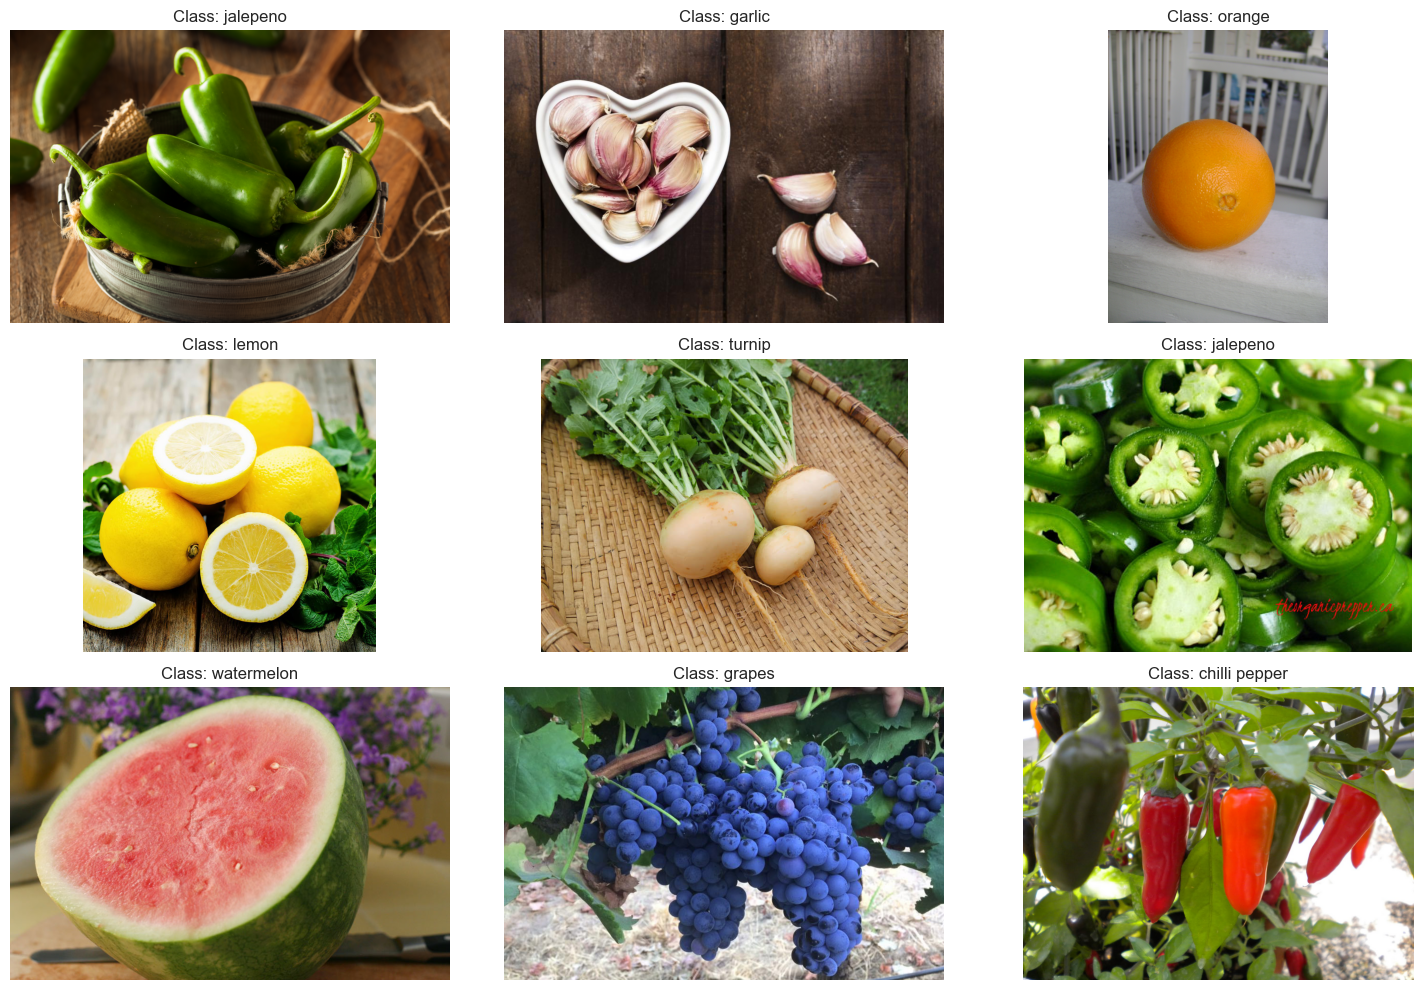

In [7]:
def explore_data(data_path):
    """Explore and visualize the dataset"""
    print("\nExploring Dataset Structure:")
    print("-" * 50)
    
    splits = ['train', 'validation', 'test']
    for split in splits:
        split_path = os.path.join(data_path, split)
        if os.path.exists(split_path):
            classes = sorted(os.listdir(split_path))
            total_images = sum(len(os.listdir(os.path.join(split_path, cls))) 
                             for cls in classes)
            
            print(f"\n{split.capitalize()} Set:")
            print(f"Number of classes: {len(classes)}")
            print(f"Total images: {total_images}")
            print(f"Example classes: {', '.join(classes[:5])}...")
    
    # Visualize sample images
    print("\nVisualizing Sample Images...")
    train_path = os.path.join(data_path, 'train')
    classes = sorted(os.listdir(train_path))
    
    plt.figure(figsize=(15, 10))
    for i in range(9):
        class_name = random.choice(classes)
        class_path = os.path.join(train_path, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        img = Image.open(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/sample_images.png')
    plt.show()

# Explore dataset
explore_data(root_path)

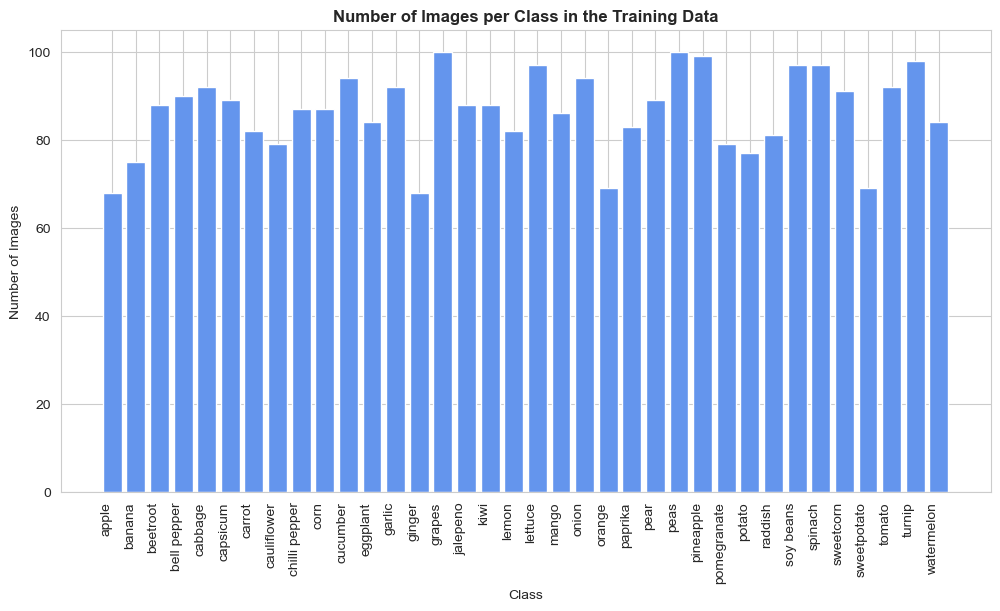

In [8]:
# Get the list of all subdirectories (classes)
classes = os.listdir(root_path + '/train')

# Count the number of images in each class
image_count = {cls: len(os.listdir(os.path.join(root_path + '/train', cls))) for cls in classes}

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(image_count.keys(), image_count.values(), color='cornflowerblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Training Data', fontweight="bold")
plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
plt.show()

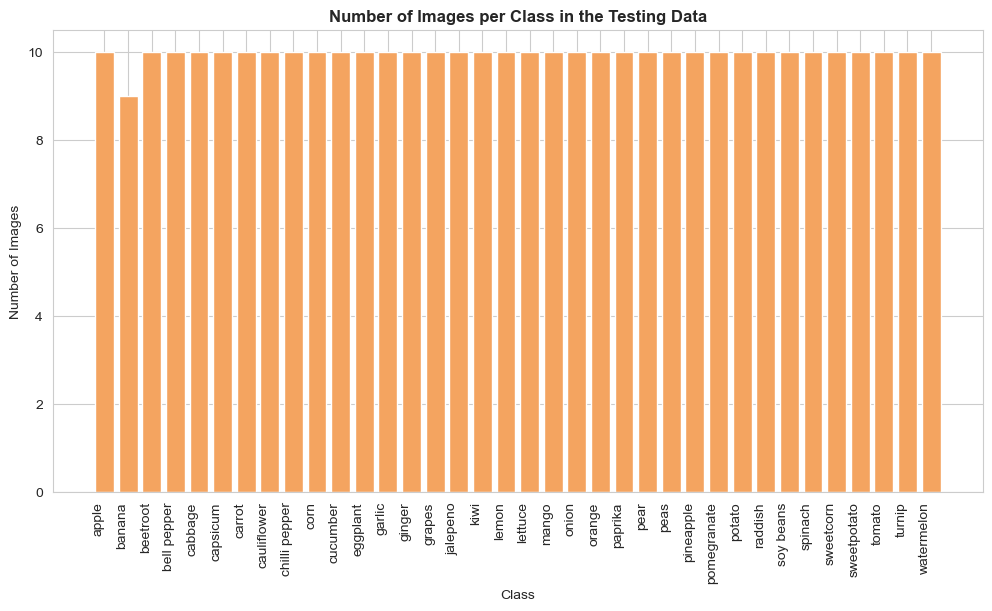

In [9]:
# Get the list of all subdirectories (classes)
classes = os.listdir(root_path + '/test')

# Count the number of images in each class
image_count = {cls: len(os.listdir(os.path.join(root_path + '/test', cls))) for cls in classes}

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(image_count.keys(), image_count.values(), color='sandybrown')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Testing Data', fontweight="bold")
plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
plt.show()

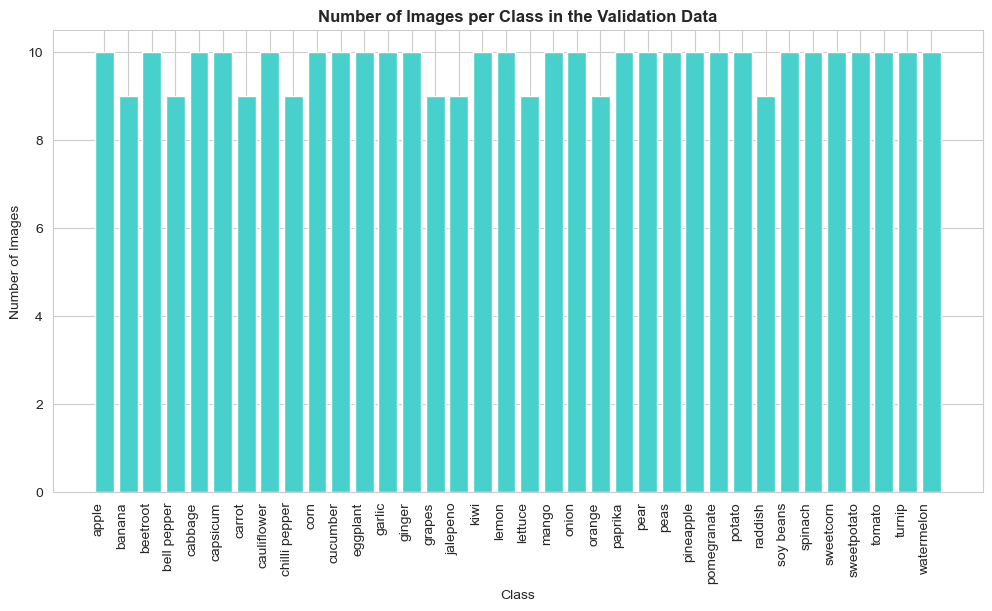

In [10]:
# Get the list of all subdirectories (classes)
classes = os.listdir(root_path + '/validation')

# Count the number of images in each class
image_count = {cls: len(os.listdir(os.path.join(root_path + '/validation', cls))) for cls in classes}

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(image_count.keys(), image_count.values(), color='mediumturquoise')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Validation Data', fontweight="bold")
plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
plt.show()

# Preprocess

In [11]:
# Define paths
input_dirs = {
    'train': 'data/36_classes/train',
    'validation': 'data/36_classes/validation',
    'test': 'data/36_classes/test'
}
output_dir = 'results/resized/'

# Create output directory and subdirectories if they don't exist
for subset in input_dirs.keys():
    subset_dir = os.path.join(output_dir, subset)
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

def resize_and_save_image(input_path, output_path, size=(128, 128)):
    try:
        with Image.open(input_path) as img:
            # Handle images with Transparency in Palette mode
            if img.mode == 'P':
                img = img.convert('RGBA')
            # Convert image to RGB if it has an alpha channel or is Palette based
            if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                img = img.convert('RGB')
            img = img.resize(size, Image.LANCZOS)
            img.save(output_path, format='JPEG')
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

def process_directory(input_directory, output_directory):
    for root, dirs, files in tqdm(os.walk(input_directory)):
        # Create the corresponding directory structure in the output directory
        relative_path = os.path.relpath(root, input_directory)
        output_path = os.path.join(output_directory, relative_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        # Process each image file
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_file_path = os.path.join(root, file_name)
                output_file_path = os.path.join(output_path, file_name)
                resize_and_save_image(input_file_path, output_file_path)

# Process each directory separately
for subset, dir_path in input_dirs.items():
    process_directory(dir_path, os.path.join(output_dir, subset))

print("Resizing and saving images completed.")

37it [02:09,  3.50s/it]
37it [00:20,  1.82it/s]
37it [00:20,  1.82it/s]

Resizing and saving images completed.


Example of resized images:



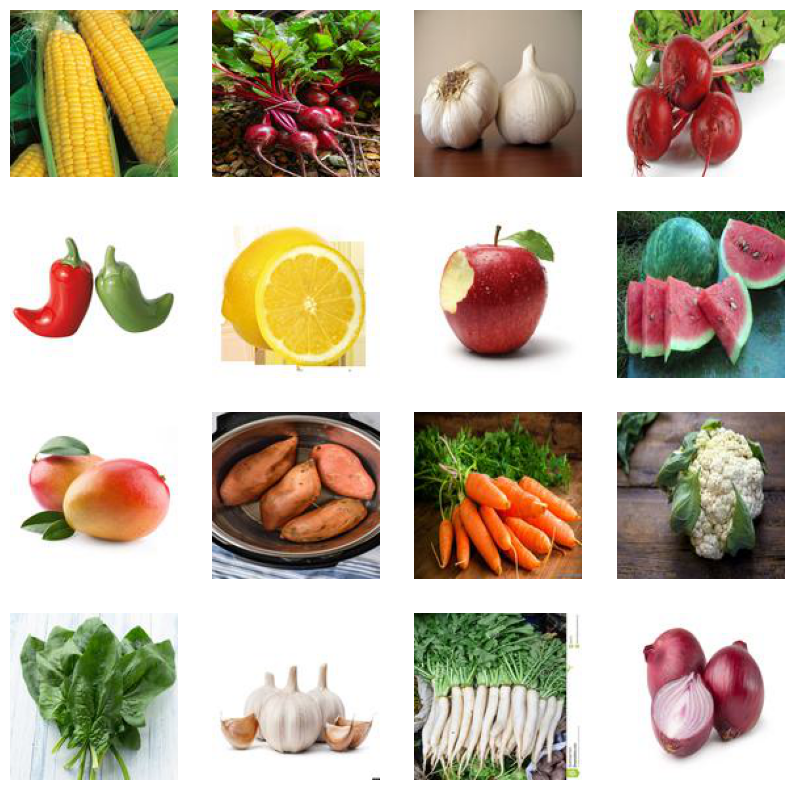

In [12]:
print('Example of resized images:\n')
# Define the path to your test directory
vis_dir = 'results/resized/test'

# Get the list of all subdirectories (classes)
classes = os.listdir(vis_dir)

# Initialize an empty list to store file paths
image_paths = []

# Loop through each class folder and collect a few image paths
for cls in classes:
    class_dir = os.path.join(vis_dir, cls)
    images = os.listdir(class_dir)
    for img in images:
        image_paths.append(os.path.join(class_dir, img))

# Randomly select 16 images from the test set
random_images = random.sample(image_paths, 16)

# Set up a 4x4 grid for plotting
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through the grid and add an image to each subplot
for i, ax in enumerate(axes.flat):
    img = Image.open(random_images[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axes

## Transformers

In [13]:
data_dir = 'results/resized'

# Transformers
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

# DataLoader
batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check
if __name__ == "__main__":
    for images, labels in train_loader:
        print(f"Batch image tensor size: {images.size()}")  # should be [batch_size, 3, 128, 128]
        print(f"Batch labels size: {labels.size()}")
        break

Batch image tensor size: torch.Size([32, 3, 128, 128])
Batch labels size: torch.Size([32])


In [14]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

print(f"Number of classes in train: {len(train_loader.dataset.classes)}")
print(f"Classes: {train_loader.dataset.classes}")


Train dataset size: 3115
Validation dataset size: 351
Test dataset size: 359
Number of classes in train: 36
Classes: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [15]:
def iterate_dataloader(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch  

    print(f"Images: {images.shape}") 
    print(f"Labels: {labels.shape}") 
    print(f"# Batches: {len(data_loader)}")  

In [16]:
# data loader for train
iterate_dataloader(train_loader)

Images: torch.Size([32, 3, 128, 128])
Labels: torch.Size([32])
# Batches: 98


In [17]:
# data loader for test
iterate_dataloader(test_loader)

Images: torch.Size([32, 3, 128, 128])
Labels: torch.Size([32])
# Batches: 12


In [18]:
# data loader for validation
iterate_dataloader(val_loader)

Images: torch.Size([32, 3, 128, 128])
Labels: torch.Size([32])
# Batches: 11


# Build architecture

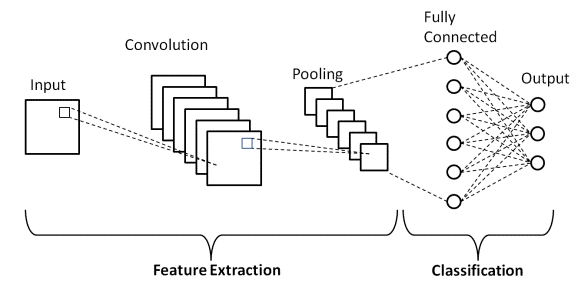

In [29]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),  # Convolution
            nn.BatchNorm2d(out_channels),                         # Normalization
            nn.ReLU(inplace=True),                               # Activation
            nn.Conv2d(out_channels, out_channels, 3, padding=1),  # Convolution
            nn.BatchNorm2d(out_channels),                         # Normalization
            nn.ReLU(inplace=True),                               # Activation
            nn.MaxPool2d(2)                                      # Pooling
        )
        
    def forward(self, x):
        return self.conv(x)

class FruitVegCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.features = nn.Sequential(
            ConvBlock(3, 64),  
            ConvBlock(64, 128), 
            ConvBlock(128, 256), 
            ConvBlock(256, 512), 
            ConvBlock(512, 512) 
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  
            nn.Flatten(),             
            nn.Dropout(0.5),          
            nn.Linear(512, 256),      
            nn.ReLU(inplace=True),    
            nn.Dropout(0.5),        
            nn.Linear(256, num_classes) 
        )
        
    def forward(self, x):
        x = self.features(x)    
        x = self.classifier(x) 
        return x

model = FruitVegCNN(num_classes=len(train_loader.dataset.classes))

The FruitVegCNN model is a convolutional neural network designed for image classification tasks, specifically for distinguishing between fruit and vegetable categories. It consists of the following components:

- **ConvBlock**:
        A building block of the network that includes two convolutional layers, batch normalization, ReLU activations, and max-pooling for dimensionality reduction. It helps to learn spatial features from the input images.
        Each block processes the input image through two convolutional layers followed by normalization and activation, then reduces the spatial dimensions via max-pooling.

- **Features**:
        The model consists of a sequence of five ConvBlocks, with increasing output channels (64, 128, 256, 512, and 512) to capture more complex features at deeper layers.

- **Classifier**:
        After the convolutional layers, the model uses AdaptiveAvgPool2d to reduce the spatial dimensions to a single value, followed by a Flatten operation.
        A Dropout layer is used for regularization to avoid overfitting.
        A Linear layer is used to map the features to a smaller vector, followed by another Dropout and a final Linear layer that outputs the class probabilities (with the number of output units equal to the number of classes).

This architecture combines deep convolutional layers with regularization techniques, making it suitable for image classification tasks like identifying fruits and vegetables.

In [31]:
model.to(device)

FruitVegCNN(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
total_params = sum(p.numel() for p in model.parameters())

print(f'Total number of parameters: {total_params}')

Total number of parameters: 9551460


Here we can see what each block and each function in layer do to our image

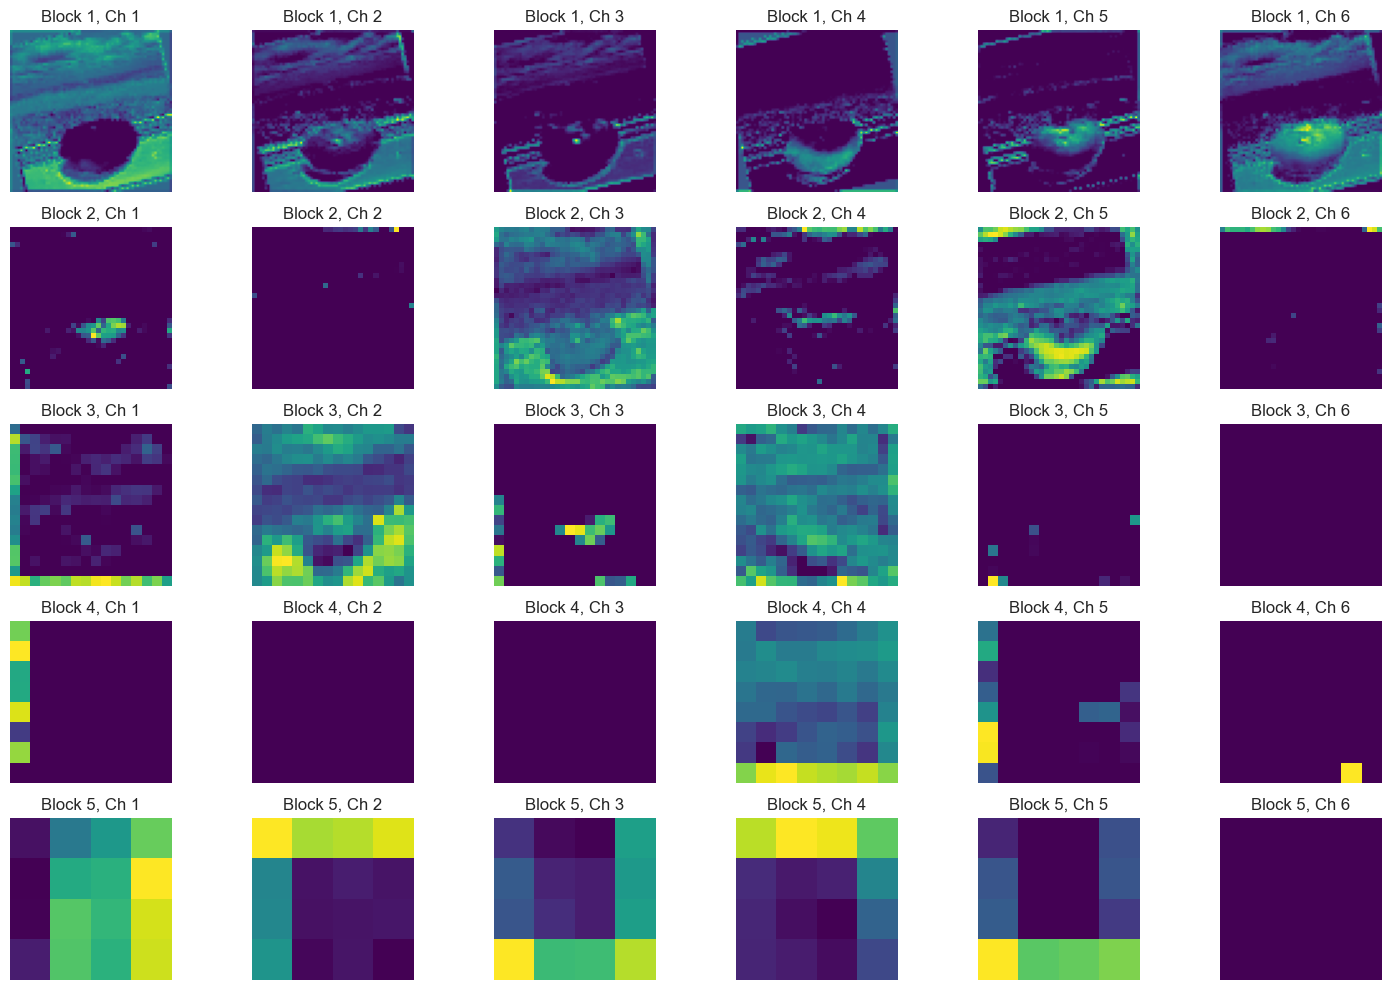

In [34]:
def visualize_feature_maps(model, sample_image):
    """Visualize feature maps after each conv block"""
    model.eval()

    feature_maps = []
    x = sample_image.unsqueeze(0).to(device)
    
    for block in model.features:
        x = block(x)
        feature_maps.append(x.detach().cpu())

    plt.figure(figsize=(15, 10))
    for i, fmap in enumerate(feature_maps):
        fmap = fmap[0][:6].permute(1, 2, 0)
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
        
        for j in range(min(6, fmap.shape[-1])):
            plt.subplot(5, 6, i*6 + j + 1)
            plt.imshow(fmap[:, :, j], cmap='viridis')
            plt.title(f'Block {i+1}, Ch {j+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/feature_maps.png')
    plt.show()

sample_image, _ = train_dataset[5]
visualize_feature_maps(model, sample_image)

# Training and Testing models

# First model


Starting training...

Epoch 1/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Train Loss: 3.3584 | Train Acc: 7.26%
Val Loss: 2.8090 | Val Acc: 15.38%
New best validation accuracy: 15.38%

Epoch 2/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.09it/s]


Train Loss: 3.0699 | Train Acc: 10.85%
Val Loss: 2.6121 | Val Acc: 16.52%
New best validation accuracy: 16.52%

Epoch 3/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


Train Loss: 2.9641 | Train Acc: 12.01%
Val Loss: 2.5858 | Val Acc: 15.95%

Epoch 4/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


Train Loss: 2.8856 | Train Acc: 13.16%
Val Loss: 2.5612 | Val Acc: 15.67%

Epoch 5/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


Train Loss: 2.8006 | Train Acc: 14.80%
Val Loss: 2.3200 | Val Acc: 25.07%


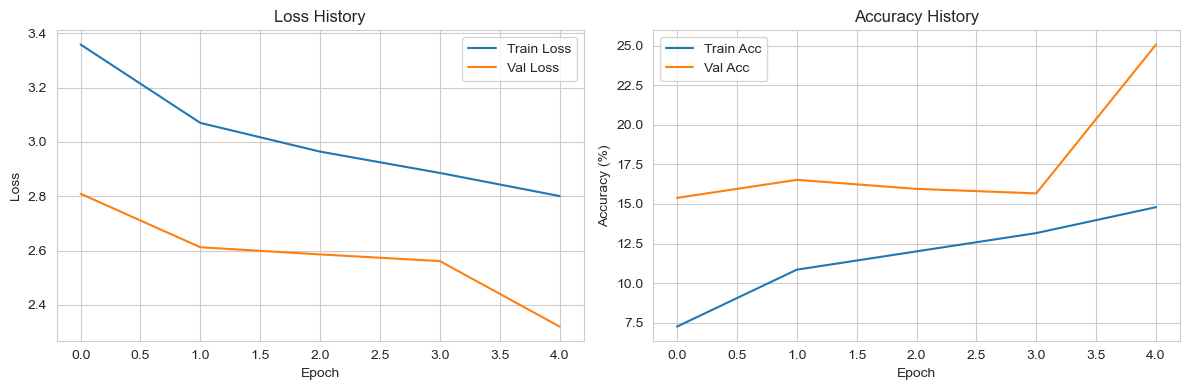

New best validation accuracy: 25.07%

Epoch 6/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Train Loss: 2.7350 | Train Acc: 16.08%
Val Loss: 2.3752 | Val Acc: 23.08%

Epoch 7/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]


Train Loss: 2.6654 | Train Acc: 18.43%
Val Loss: 2.1784 | Val Acc: 29.91%
New best validation accuracy: 29.91%

Epoch 8/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


Train Loss: 2.6294 | Train Acc: 19.07%
Val Loss: 2.3619 | Val Acc: 24.79%

Epoch 9/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s]


Train Loss: 2.6096 | Train Acc: 19.71%
Val Loss: 2.1154 | Val Acc: 35.04%
New best validation accuracy: 35.04%

Epoch 10/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]


Train Loss: 2.5847 | Train Acc: 19.61%
Val Loss: 2.0571 | Val Acc: 29.91%


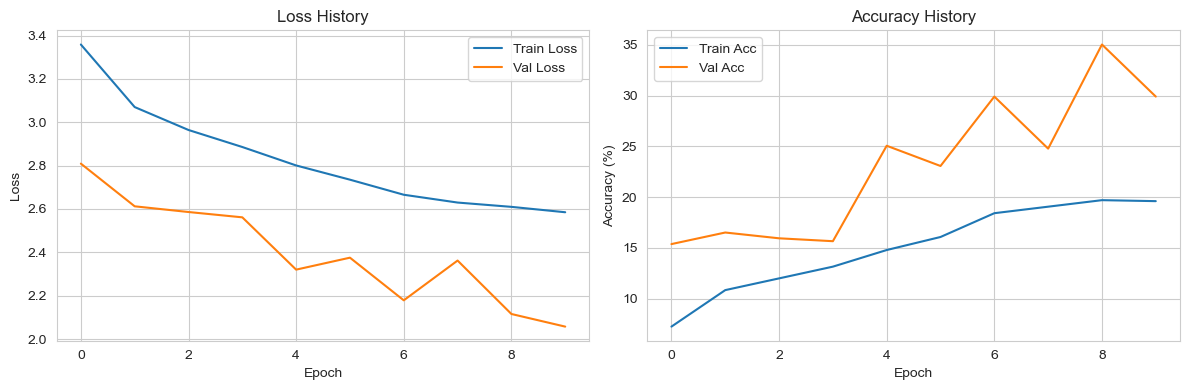


Epoch 11/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]


Train Loss: 2.5563 | Train Acc: 21.41%
Val Loss: 2.0723 | Val Acc: 31.62%

Epoch 12/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.15it/s]


Train Loss: 2.5353 | Train Acc: 22.70%
Val Loss: 2.0659 | Val Acc: 33.90%

Epoch 13/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.10it/s]


Train Loss: 2.4904 | Train Acc: 22.70%
Val Loss: 1.8808 | Val Acc: 41.31%
New best validation accuracy: 41.31%

Epoch 14/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.31it/s]


Train Loss: 2.4794 | Train Acc: 24.69%
Val Loss: 1.9634 | Val Acc: 38.75%

Epoch 15/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Train Loss: 2.4427 | Train Acc: 25.26%
Val Loss: 1.8669 | Val Acc: 43.02%


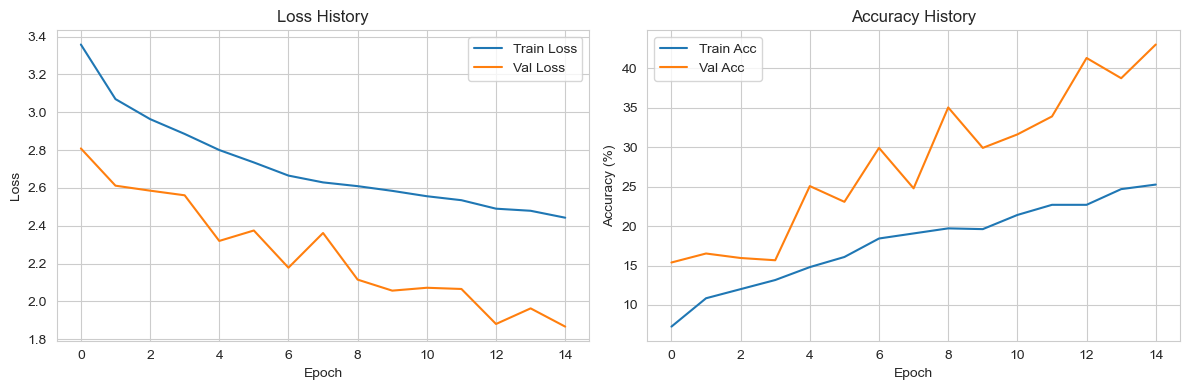

New best validation accuracy: 43.02%

Epoch 16/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


Train Loss: 2.4070 | Train Acc: 24.65%
Val Loss: 1.8422 | Val Acc: 42.74%

Epoch 17/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Train Loss: 2.3816 | Train Acc: 25.30%
Val Loss: 2.0246 | Val Acc: 30.20%

Epoch 18/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


Train Loss: 2.3876 | Train Acc: 26.23%
Val Loss: 1.7565 | Val Acc: 43.59%
New best validation accuracy: 43.59%

Epoch 19/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


Train Loss: 2.3394 | Train Acc: 28.22%
Val Loss: 2.0227 | Val Acc: 37.89%

Epoch 20/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


Train Loss: 2.3844 | Train Acc: 27.19%
Val Loss: 1.7431 | Val Acc: 47.01%


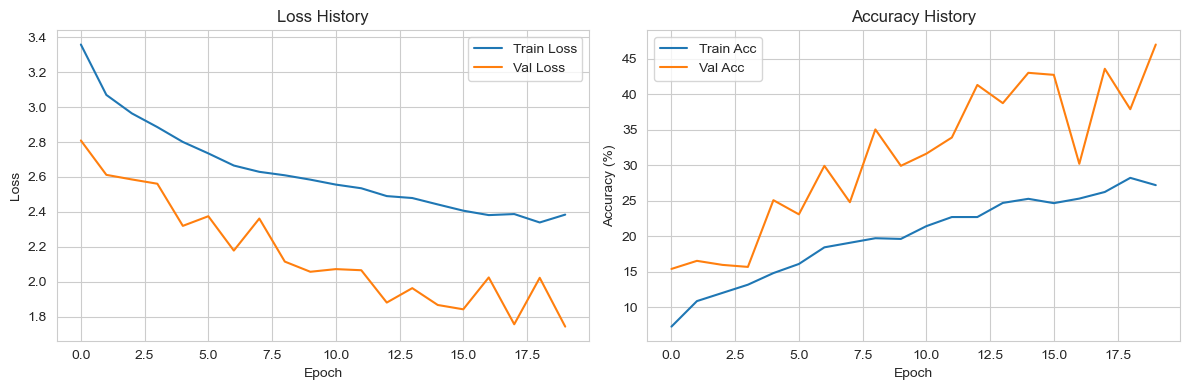

New best validation accuracy: 47.01%

Epoch 21/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


Train Loss: 2.2717 | Train Acc: 28.54%
Val Loss: 1.7156 | Val Acc: 45.01%

Epoch 22/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


Train Loss: 2.2882 | Train Acc: 28.83%
Val Loss: 1.6645 | Val Acc: 47.58%
New best validation accuracy: 47.58%

Epoch 23/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.20it/s]


Train Loss: 2.2486 | Train Acc: 29.28%
Val Loss: 1.6111 | Val Acc: 48.72%
New best validation accuracy: 48.72%

Epoch 24/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.06it/s]


Train Loss: 2.2628 | Train Acc: 30.40%
Val Loss: 1.5670 | Val Acc: 48.15%

Epoch 25/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024A3D17CD60>
Traceback (most recent call last):
  File "C:\Users\p1tsa\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\p1tsa\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Train Loss: 2.2213 | Train Acc: 32.33%
Val Loss: 1.6610 | Val Acc: 46.72%


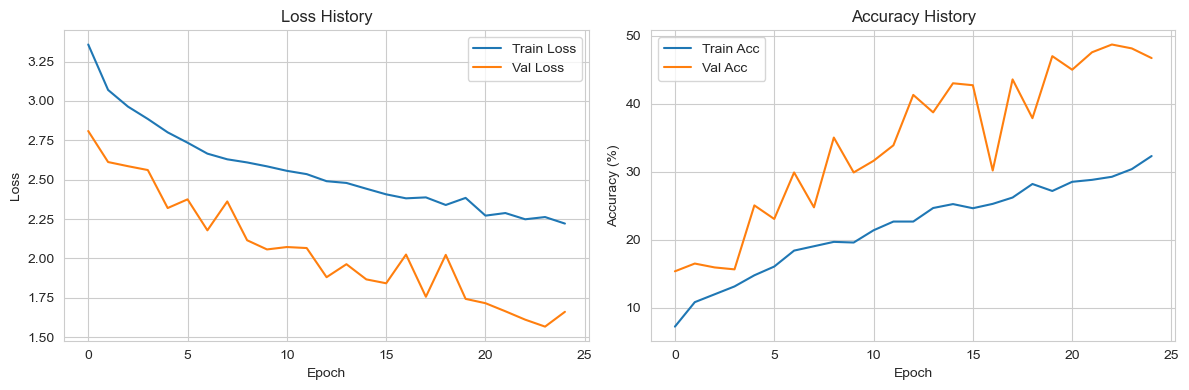


Epoch 26/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.15it/s]


Train Loss: 2.1785 | Train Acc: 32.62%
Val Loss: 1.6875 | Val Acc: 42.45%

Epoch 27/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


Train Loss: 2.2114 | Train Acc: 32.97%
Val Loss: 1.5752 | Val Acc: 48.72%

Epoch 28/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


Train Loss: 2.1613 | Train Acc: 32.94%
Val Loss: 1.6008 | Val Acc: 45.58%

Epoch 29/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


Train Loss: 2.0749 | Train Acc: 34.54%
Val Loss: 1.3504 | Val Acc: 60.40%
New best validation accuracy: 60.40%

Epoch 30/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


Train Loss: 2.0437 | Train Acc: 36.47%
Val Loss: 1.3860 | Val Acc: 59.54%


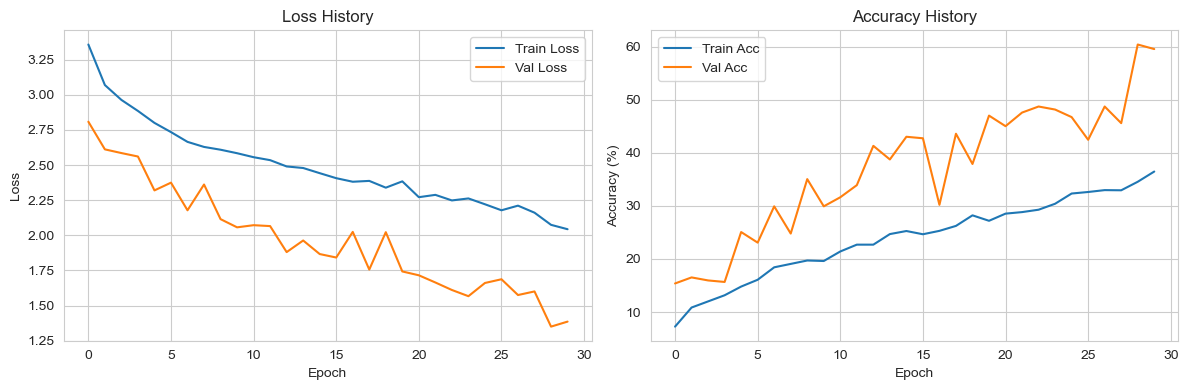


Epoch 31/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


Train Loss: 2.0046 | Train Acc: 36.95%
Val Loss: 1.3023 | Val Acc: 58.40%

Epoch 32/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


Train Loss: 1.9729 | Train Acc: 37.78%
Val Loss: 1.2687 | Val Acc: 61.54%
New best validation accuracy: 61.54%

Epoch 33/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


Train Loss: 2.0086 | Train Acc: 36.76%
Val Loss: 1.4372 | Val Acc: 53.28%

Epoch 34/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


Train Loss: 1.9569 | Train Acc: 37.98%
Val Loss: 1.3726 | Val Acc: 57.55%

Epoch 35/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.95it/s]


Train Loss: 1.9298 | Train Acc: 39.90%
Val Loss: 1.2535 | Val Acc: 58.69%


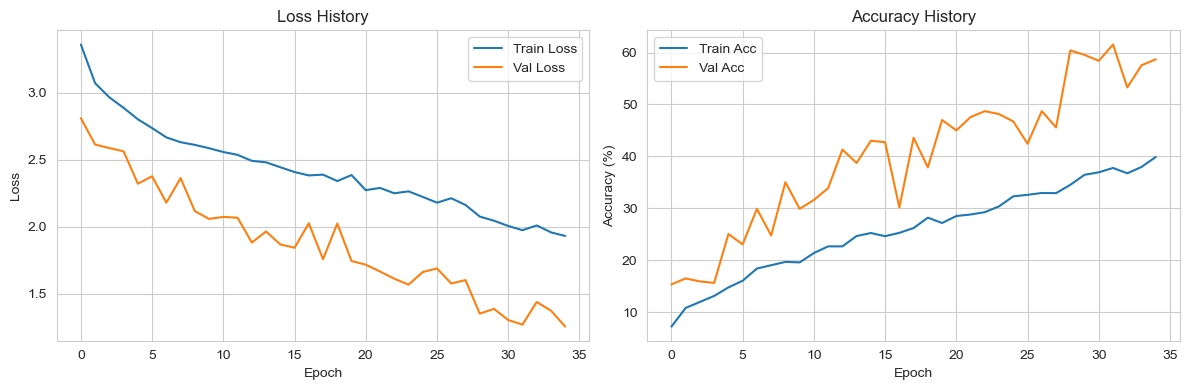


Epoch 36/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.97it/s]


Train Loss: 1.9726 | Train Acc: 37.88%
Val Loss: 1.2995 | Val Acc: 59.54%

Epoch 37/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


Train Loss: 1.9184 | Train Acc: 39.10%
Val Loss: 1.2583 | Val Acc: 62.68%
New best validation accuracy: 62.68%

Epoch 38/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]


Train Loss: 1.9015 | Train Acc: 39.33%
Val Loss: 1.1363 | Val Acc: 65.53%
New best validation accuracy: 65.53%

Epoch 39/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


Train Loss: 1.8733 | Train Acc: 41.09%
Val Loss: 1.2473 | Val Acc: 62.96%

Epoch 40/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


Train Loss: 1.8770 | Train Acc: 40.48%
Val Loss: 1.1683 | Val Acc: 64.39%


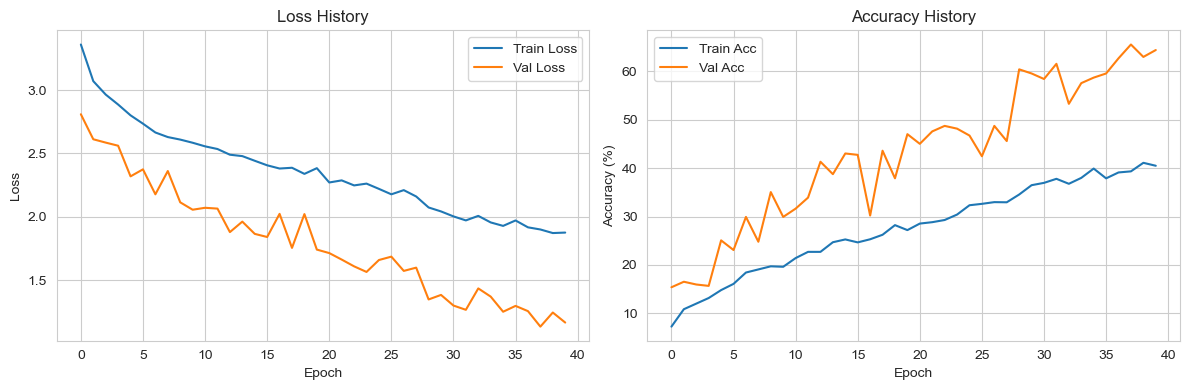


Epoch 41/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


Train Loss: 1.8759 | Train Acc: 40.26%
Val Loss: 1.1795 | Val Acc: 60.97%

Epoch 42/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


Train Loss: 1.8689 | Train Acc: 41.77%
Val Loss: 1.1316 | Val Acc: 63.82%

Epoch 43/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


Train Loss: 1.8071 | Train Acc: 42.25%
Val Loss: 1.1317 | Val Acc: 63.53%

Epoch 44/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.98it/s]


Train Loss: 1.7837 | Train Acc: 43.98%
Val Loss: 1.1328 | Val Acc: 64.96%

Epoch 45/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.11it/s]


Train Loss: 1.8060 | Train Acc: 44.17%
Val Loss: 1.1235 | Val Acc: 69.80%


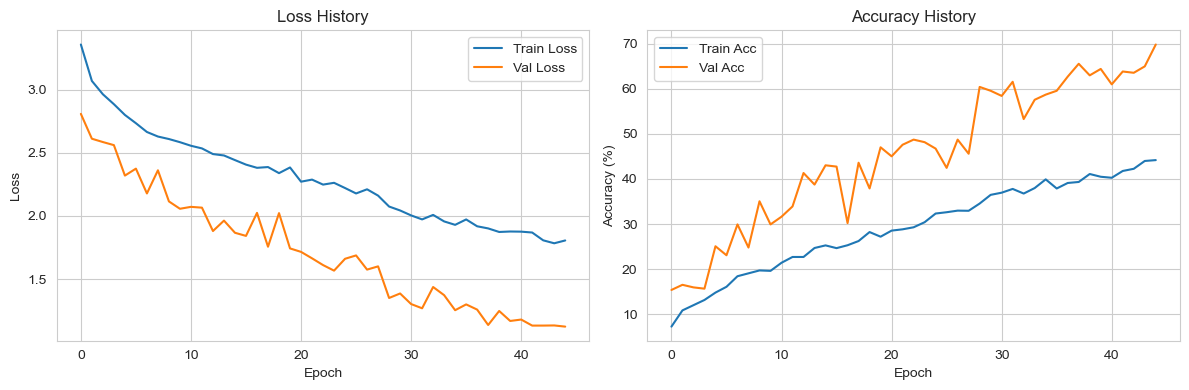

New best validation accuracy: 69.80%

Epoch 46/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.92it/s]


Train Loss: 1.7652 | Train Acc: 43.92%
Val Loss: 1.1400 | Val Acc: 63.25%

Epoch 47/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]


Train Loss: 1.7361 | Train Acc: 44.88%
Val Loss: 1.0430 | Val Acc: 67.81%

Epoch 48/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.10it/s]


Train Loss: 1.7256 | Train Acc: 45.07%
Val Loss: 1.0008 | Val Acc: 70.37%
New best validation accuracy: 70.37%

Epoch 49/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]


Train Loss: 1.7351 | Train Acc: 44.78%
Val Loss: 1.0003 | Val Acc: 70.37%

Epoch 50/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.06it/s]


Train Loss: 1.6846 | Train Acc: 47.38%
Val Loss: 0.9869 | Val Acc: 69.23%


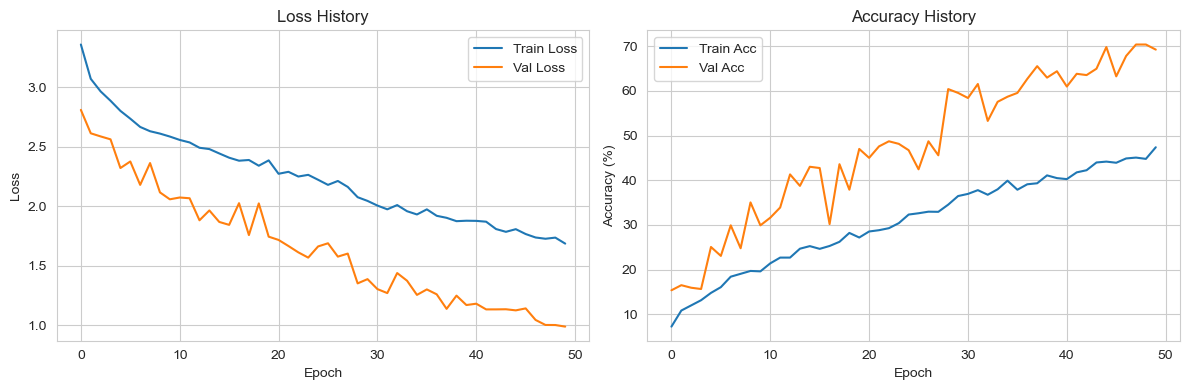

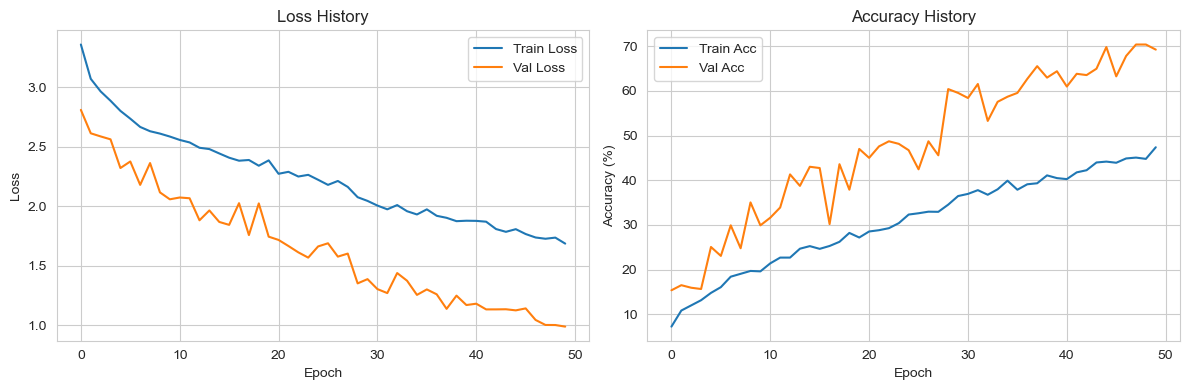

In [35]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(val_loader), 100. * correct / total

def plot_training_progress(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('results/training_progress.png')
    plt.show()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 50
best_val_acc = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\nStarting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device)
    
    val_loss, val_acc = validate(
        model, val_loader, criterion, device)
    

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    if (epoch + 1) % 5 == 0:
        plot_training_progress(history)
    
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f'New best validation accuracy: {best_val_acc:.2f}%')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_val_acc,
        }, 'results/best_model.pth')


plot_training_progress(history)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

def testing(model, test_loader, device):
    model.eval()  

    test_results = []
    lst_ytest = []
    lst_ypred = []

    with torch.no_grad():  
        for images, labels in test_loader:  
            images, labels = images.to(device), labels.to(device) 

            logits = model(images)  
            y_probs = F.softmax(logits, dim=1).cpu().numpy() 
            y_pred = np.argmax(y_probs, axis=1)

            lst_ytest.extend(labels.cpu().numpy()) 
            lst_ypred.extend(y_pred)

    accuracy = accuracy_score(lst_ytest, lst_ypred)
    precision = precision_score(lst_ytest, lst_ypred, average='weighted')
    recall = recall_score(lst_ytest, lst_ypred, average='weighted')
    f1 = f1_score(lst_ytest, lst_ypred, average='weighted')

    test_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    frame_results = pd.DataFrame(test_results)

    return frame_results


In [42]:
testing_results = testing(model, test_loader, device)
print(testing_results)


   accuracy  precision    recall  f1_score
0  0.690808   0.713967  0.690808  0.678789


In [45]:
import pickle

with open('models/model_cnn.pkl', 'wb') as f:
    pickle.dump(model, f)

# Second model

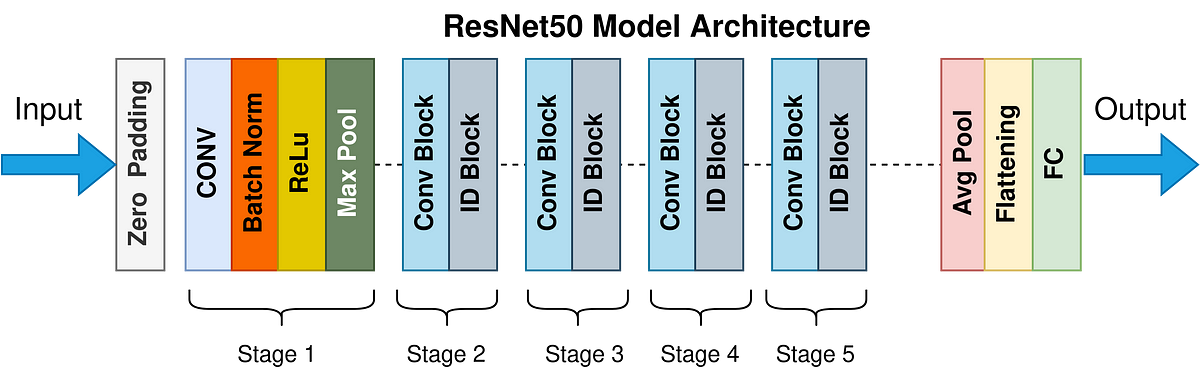

**ResNet50** is a deep neural network with 50 layers, designed to solve the vanishing gradient problem. It uses residual connections (skip connections) that allow gradients to bypass layers, improving training in deep networks. The architecture includes bottleneck blocks for efficient computation and pre-activation where batch normalization and activation layers come before convolutions. ResNet50 is widely used for image classification and computer vision tasks due to its deep structure and effective training capabilities.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
from tqdm import tqdm

class ResNet50Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Custom, self).__init__()
        
        self.backbone = models.resnet50(pretrained=True)

        for param in self.backbone.parameters():
            param.requires_grad = False
        
        num_features = self.backbone.fc.in_features 
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 1024),             
            nn.BatchNorm1d(1024),              
            nn.ReLU(inplace=True), 
            nn.Dropout(0.5),            
            nn.Linear(1024, 512),                   
            nn.BatchNorm1d(512),   
            nn.ReLU(inplace=True), 
            nn.Dropout(0.5),       
            nn.Linear(512, num_classes)             
        )

    def forward(self, x):
        return self.backbone(x)

config = {
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 50
}

def train_with_optimization(model, train_loader, val_loader, config, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  
    optimizer = optim.AdamW(model.parameters(), 
                            lr=config['learning_rate'], 
                            weight_decay=config['weight_decay']) 
    
    scheduler = OneCycleLR(optimizer,
                           max_lr=config['learning_rate'],
                           epochs=config['epochs'],
                           steps_per_epoch=len(train_loader),
                           pct_start=0.1,
                           anneal_strategy='cos')  

    scaler = GradScaler() 
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0 
    
    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epochs"]}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })
        
        train_acc = 100. * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'\nEpoch {epoch+1}/{config["epochs"]}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_val_acc,
            }, 'resnet50_custom_model.pth')
            print(f'New best validation accuracy: {best_val_acc:.2f}%')
    
    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50Custom(num_classes=len(train_loader.dataset.classes)).to(device)

history = train_with_optimization(model, train_loader, val_loader, config, device)

C:\Users\p1tsa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\p1tsa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\p1tsa\AppData\Local\Temp\ipykernel_5684\2601241223.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Скаляр для обучения с использованием смешанной точности
Epoch 1/50:   0%|                                                                             


Epoch 1/50:
Train Loss: 3.4671 | Train Acc: 9.98%
Val Loss: 2.7423 | Val Acc: 60.97%
New best validation accuracy: 60.97%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]



Epoch 2/50:
Train Loss: 2.6045 | Train Acc: 41.32%
Val Loss: 1.6978 | Val Acc: 76.64%
New best validation accuracy: 76.64%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.08it/s]



Epoch 3/50:
Train Loss: 1.9777 | Train Acc: 58.43%
Val Loss: 1.3262 | Val Acc: 81.77%
New best validation accuracy: 81.77%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]



Epoch 4/50:
Train Loss: 1.7753 | Train Acc: 62.38%
Val Loss: 1.2082 | Val Acc: 82.34%
New best validation accuracy: 82.34%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s]



Epoch 5/50:
Train Loss: 1.7041 | Train Acc: 64.46%
Val Loss: 1.1332 | Val Acc: 86.61%
New best validation accuracy: 86.61%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.30it/s]



Epoch 6/50:
Train Loss: 1.6357 | Train Acc: 67.13%
Val Loss: 1.1301 | Val Acc: 86.32%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]



Epoch 7/50:
Train Loss: 1.5773 | Train Acc: 69.28%
Val Loss: 1.1010 | Val Acc: 88.03%
New best validation accuracy: 88.03%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]



Epoch 8/50:
Train Loss: 1.5386 | Train Acc: 70.59%
Val Loss: 1.0725 | Val Acc: 87.46%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]



Epoch 9/50:
Train Loss: 1.4913 | Train Acc: 72.30%
Val Loss: 1.0648 | Val Acc: 89.46%
New best validation accuracy: 89.46%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]



Epoch 10/50:
Train Loss: 1.4764 | Train Acc: 72.58%
Val Loss: 1.0536 | Val Acc: 90.31%
New best validation accuracy: 90.31%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]



Epoch 11/50:
Train Loss: 1.4603 | Train Acc: 72.81%
Val Loss: 1.0224 | Val Acc: 90.88%
New best validation accuracy: 90.88%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 12/50:
Train Loss: 1.4188 | Train Acc: 74.74%
Val Loss: 1.0470 | Val Acc: 89.46%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 13/50:
Train Loss: 1.4233 | Train Acc: 74.80%
Val Loss: 1.0351 | Val Acc: 90.60%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]



Epoch 14/50:
Train Loss: 1.3954 | Train Acc: 75.38%
Val Loss: 1.0354 | Val Acc: 89.46%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 15/50:
Train Loss: 1.3679 | Train Acc: 77.43%
Val Loss: 1.0227 | Val Acc: 90.60%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]



Epoch 16/50:
Train Loss: 1.3593 | Train Acc: 77.66%
Val Loss: 0.9932 | Val Acc: 91.45%
New best validation accuracy: 91.45%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.08it/s]



Epoch 17/50:
Train Loss: 1.3362 | Train Acc: 78.04%
Val Loss: 0.9936 | Val Acc: 91.74%
New best validation accuracy: 91.74%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 18/50:
Train Loss: 1.3119 | Train Acc: 79.87%
Val Loss: 0.9815 | Val Acc: 90.88%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]



Epoch 19/50:
Train Loss: 1.3009 | Train Acc: 80.58%
Val Loss: 0.9780 | Val Acc: 91.74%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.15it/s]



Epoch 20/50:
Train Loss: 1.2954 | Train Acc: 79.13%
Val Loss: 0.9586 | Val Acc: 91.74%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]



Epoch 21/50:
Train Loss: 1.2962 | Train Acc: 79.81%
Val Loss: 0.9734 | Val Acc: 92.88%
New best validation accuracy: 92.88%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.05it/s]



Epoch 22/50:
Train Loss: 1.2541 | Train Acc: 81.73%
Val Loss: 0.9405 | Val Acc: 94.59%
New best validation accuracy: 94.59%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.59it/s]



Epoch 23/50:
Train Loss: 1.2782 | Train Acc: 80.64%
Val Loss: 0.9256 | Val Acc: 94.59%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 24/50:
Train Loss: 1.2343 | Train Acc: 82.18%
Val Loss: 0.9547 | Val Acc: 93.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.96it/s]



Epoch 25/50:
Train Loss: 1.2228 | Train Acc: 82.66%
Val Loss: 0.9410 | Val Acc: 94.59%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.77it/s]



Epoch 26/50:
Train Loss: 1.2251 | Train Acc: 82.70%
Val Loss: 0.9417 | Val Acc: 94.30%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]



Epoch 27/50:
Train Loss: 1.2054 | Train Acc: 83.43%
Val Loss: 0.9323 | Val Acc: 94.30%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.08it/s]



Epoch 28/50:
Train Loss: 1.2101 | Train Acc: 83.50%
Val Loss: 0.9343 | Val Acc: 94.30%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]



Epoch 29/50:
Train Loss: 1.1870 | Train Acc: 84.65%
Val Loss: 0.9312 | Val Acc: 94.59%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.13it/s]



Epoch 30/50:
Train Loss: 1.1819 | Train Acc: 84.72%
Val Loss: 0.9332 | Val Acc: 94.59%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.20it/s]



Epoch 31/50:
Train Loss: 1.1738 | Train Acc: 84.43%
Val Loss: 0.9218 | Val Acc: 94.87%
New best validation accuracy: 94.87%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]



Epoch 32/50:
Train Loss: 1.1544 | Train Acc: 85.49%
Val Loss: 0.9202 | Val Acc: 94.02%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.09it/s]



Epoch 33/50:
Train Loss: 1.1632 | Train Acc: 85.52%
Val Loss: 0.9221 | Val Acc: 94.02%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]



Epoch 34/50:
Train Loss: 1.1500 | Train Acc: 86.07%
Val Loss: 0.9114 | Val Acc: 94.30%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.10it/s]



Epoch 35/50:
Train Loss: 1.1428 | Train Acc: 86.65%
Val Loss: 0.9073 | Val Acc: 94.87%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]



Epoch 36/50:
Train Loss: 1.1357 | Train Acc: 86.68%
Val Loss: 0.9062 | Val Acc: 95.16%
New best validation accuracy: 95.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.16it/s]



Epoch 37/50:
Train Loss: 1.1281 | Train Acc: 87.06%
Val Loss: 0.9079 | Val Acc: 94.30%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]



Epoch 38/50:
Train Loss: 1.1000 | Train Acc: 87.64%
Val Loss: 0.8966 | Val Acc: 95.44%
New best validation accuracy: 95.44%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.27it/s]



Epoch 39/50:
Train Loss: 1.1117 | Train Acc: 88.12%
Val Loss: 0.9039 | Val Acc: 96.58%
New best validation accuracy: 96.58%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]



Epoch 40/50:
Train Loss: 1.0961 | Train Acc: 88.19%
Val Loss: 0.8936 | Val Acc: 95.73%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]



Epoch 41/50:
Train Loss: 1.1168 | Train Acc: 87.51%
Val Loss: 0.8854 | Val Acc: 96.01%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]



Epoch 42/50:
Train Loss: 1.0893 | Train Acc: 88.99%
Val Loss: 0.8959 | Val Acc: 95.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]



Epoch 43/50:
Train Loss: 1.0726 | Train Acc: 88.96%
Val Loss: 0.8898 | Val Acc: 95.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]



Epoch 44/50:
Train Loss: 1.0917 | Train Acc: 89.34%
Val Loss: 0.8871 | Val Acc: 95.44%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.22it/s]



Epoch 45/50:
Train Loss: 1.0923 | Train Acc: 88.12%
Val Loss: 0.8991 | Val Acc: 95.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.25it/s]



Epoch 46/50:
Train Loss: 1.0840 | Train Acc: 89.47%
Val Loss: 0.8932 | Val Acc: 95.44%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]



Epoch 47/50:
Train Loss: 1.0798 | Train Acc: 89.12%
Val Loss: 0.8949 | Val Acc: 95.16%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]



Epoch 48/50:
Train Loss: 1.0839 | Train Acc: 89.41%
Val Loss: 0.8934 | Val Acc: 95.73%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]



Epoch 49/50:
Train Loss: 1.0858 | Train Acc: 88.83%
Val Loss: 0.8901 | Val Acc: 95.44%


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.19it/s]


Epoch 50/50:
Train Loss: 1.0810 | Train Acc: 88.99%
Val Loss: 0.8861 | Val Acc: 95.73%


In [27]:
print(model)

ResNet50Custom(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [60]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Количество обучаемых параметров: {num_params}')

Количество обучаемых параметров: 2644516


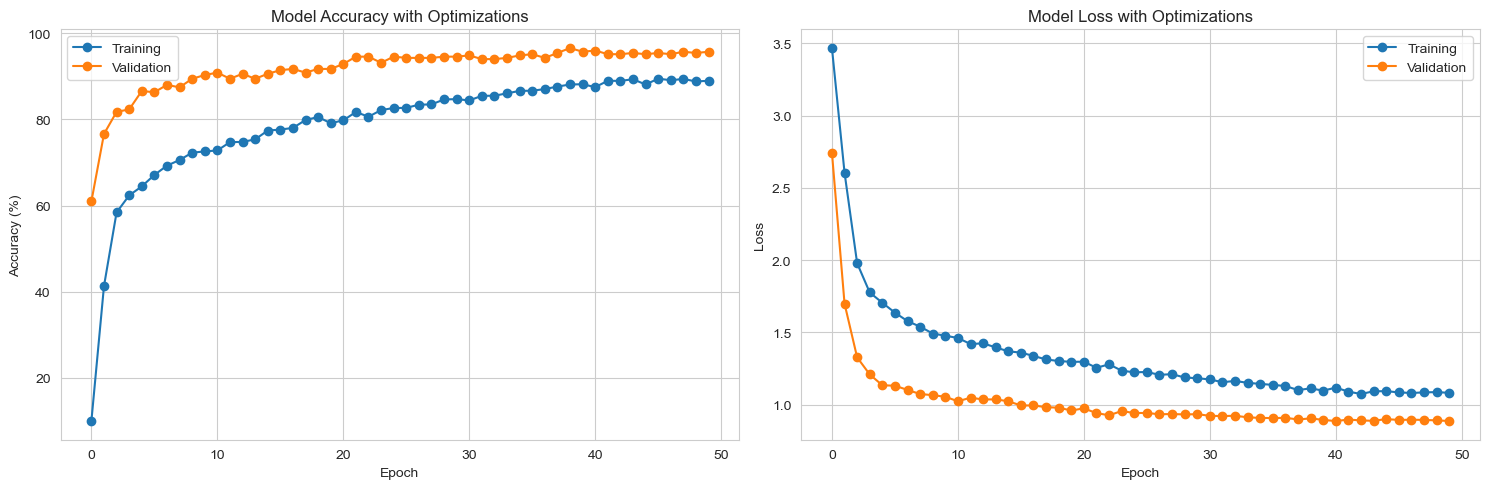


Best Training Accuracy: 89.47%
Best Validation Accuracy: 96.58%


In [22]:
def plot_optimized_results(history):
    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training', marker='o')
    plt.plot(history['val_acc'], label='Validation', marker='o')
    plt.title('Model Accuracy with Optimizations')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training', marker='o')
    plt.plot(history['val_loss'], label='Validation', marker='o')
    plt.title('Model Loss with Optimizations')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('optimized_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print best metrics
    best_train_acc = max(history['train_acc'])
    best_val_acc = max(history['val_acc'])
    print(f"\nBest Training Accuracy: {best_train_acc:.2f}%")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Plot results
plot_optimized_results(history)

In [23]:
testing_results = testing(model, test_loader, device)
print(testing_results)

   accuracy  precision    recall  f1_score
0  0.958217   0.963838  0.958217  0.957604


In [24]:
import pickle

with open('models/ResNet50Custom.pkl', 'wb') as f:
    pickle.dump(model, f)

# Monitoring

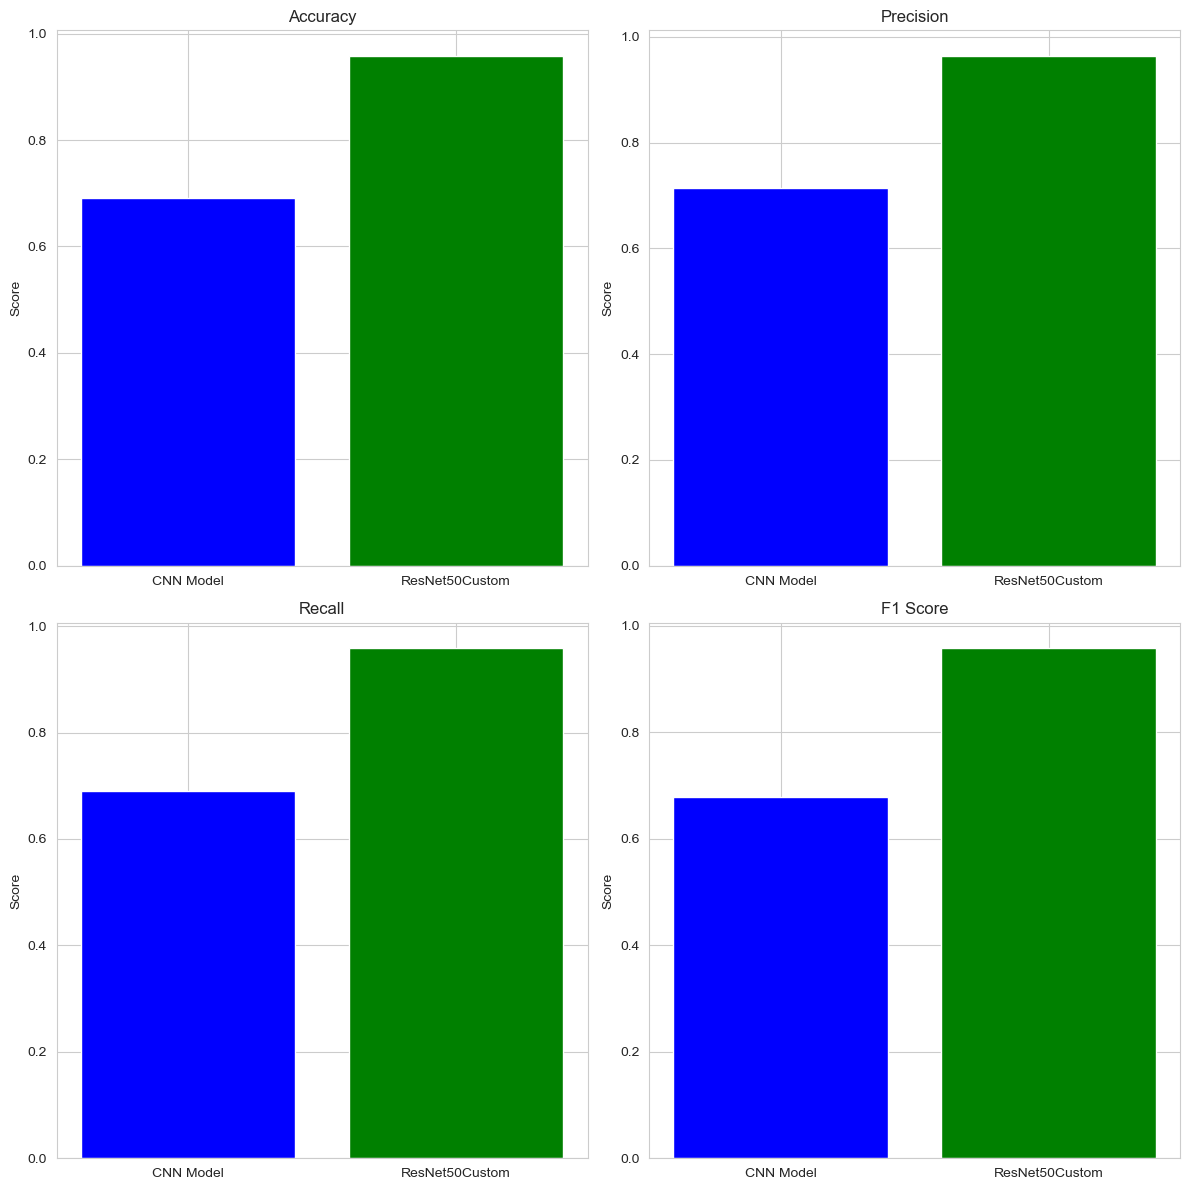

In [40]:
with open('models/model_cnn.pkl', 'rb') as f:
    model1 = pickle.load(f)

with open('models/ResNet50Custom.pkl', 'rb') as f:
    model2 = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)

results_model1 = testing(model1, test_loader, device)
results_model2 = testing(model2, test_loader, device)

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
model1_metrics = [results_model1[metric][0] for metric in metrics]
model2_metrics = [results_model2[metric][0] for metric in metrics]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].bar(['CNN Model', 'ResNet50Custom'], model1_metrics[:1] + model2_metrics[:1], color=['blue', 'green'])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylabel('Score')

axes[0, 1].bar(['CNN Model', 'ResNet50Custom'], model1_metrics[1:2] + model2_metrics[1:2], color=['blue', 'green'])
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylabel('Score')

axes[1, 0].bar(['CNN Model', 'ResNet50Custom'], model1_metrics[2:3] + model2_metrics[2:3], color=['blue', 'green'])
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylabel('Score')

axes[1, 1].bar(['CNN Model', 'ResNet50Custom'], model1_metrics[3:] + model2_metrics[3:], color=['blue', 'green'])
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

# Inference

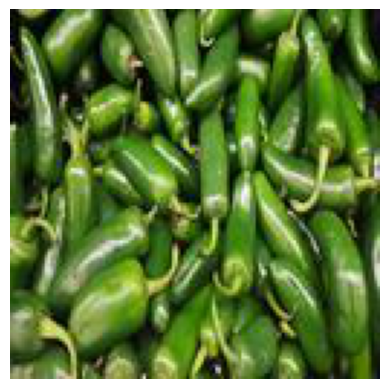

Class: jalepeno | Probability: 0.9337
Class: bell pepper | Probability: 0.0366
Class: peas | Probability: 0.0074
Class: capsicum | Probability: 0.0031
Class: soy beans | Probability: 0.0029
Class: chilli pepper | Probability: 0.0019
Class: cucumber | Probability: 0.0016
Class: spinach | Probability: 0.0013
Class: pear | Probability: 0.0013
Class: kiwi | Probability: 0.0012


In [66]:
from IPython.display import display, HTML
base_dir = 'results/resized/test'

class_folders = os.listdir(base_dir)

selected_class = random.choice(class_folders)

class_dir = os.path.join(base_dir, selected_class)
image_files = os.listdir(class_dir)
selected_image = random.choice(image_files)

img_path = os.path.join(class_dir, selected_image)
img = Image.open(img_path)

img_tensor = test_transform(img).unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = img_tensor.to(device)

model2.eval()

with torch.no_grad():
    outputs = model2(img_tensor)
    probabilities = F.softmax(outputs, dim=1)  
    _, predicted_class = torch.max(outputs, 1)  

true_class = selected_class


plt.imshow(img)
plt.axis('off')
plt.show()

display(HTML(f'<b>Predicted Class:</b> {classes[predicted_class.item()]}'))
display(HTML(f'<b>True Class:</b> {true_class}'))

display(HTML(f'<b>Probabilities for classes:</b>'))
probabilities_np = probabilities.squeeze().cpu().numpy()
sorted_indices = np.argsort(probabilities_np)[::-1]
for idx in sorted_indices[:10]:
    print(f'Class: {classes[idx]} | Probability: {probabilities_np[idx]:.4f}')